<a href="https://colab.research.google.com/github/sashafromlibertalia/deep-learning-labs/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Реализовать с помощью `Numpy` класс `MyMLP`, моделирующий работу полносвязной нейронной сети.

Реализуемый класс должен

1. Поддерживать создание любого числа слоев с любым числом нейронов. Тип инициализации весов не регламентируется.
2. Обеспечивать выбор следующих функции активации в рамках каждого слоя: `ReLU`, `sigmoid`, `linear`.
3. Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации).
4. В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча)
5. Поддерживать использование `l1`, `l2` и `l1l2` регуляризаций.

Самостоятельно выбрать наборы данных (классификация и регрессия). Провести эксперименты (различные конфигурации сети: количество слоев, нейронов, функции активации, скорость обучения и тп. — минимум 5 различных конфигураций) и сравнить результаты работы (оценка качества модели + время обучения и инференса) реализованного класса `MyMLP` со следующими моделям (в одинаковых конфигурациях):

*   MLPClassifier/MLPRegressor из sklearn
*   TensorFlow
*   Keras
*   PyTorch

Результат представить в виде .ipynb блокнота, содержащего весь необходимый код и визуализации сравнения реализаций для рассмотренных конфигураций.


# Решение

## Подготовка окружения

In [237]:
import tensorflow as tf
import tensorflow.keras as keras

from keras import losses
from keras import layers
from keras import optimizers

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.neural_network import MLPRegressor, MLPClassifier

In [238]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 500

In [239]:
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_california_housing, fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_classification, make_regression

import time
import numpy as np
import pandas as pd

%matplotlib inline

In [240]:
import warnings
warnings.filterwarnings('ignore')

In [241]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
one_hot_encoder = OneHotEncoder(sparse_output=False)

In [242]:
torch.manual_seed(42)
np.random.seed(42)

In [243]:
def map_layers_to_torch_api(config, loss):
  local_layers = config['layers']
  local_activations = config['activations']

  torch_layers = []
  torch_loss = None

  for i in range(len(local_layers) - 1):
    torch_layers.append(nn.Linear(local_layers[i], local_layers[i + 1]))

    if i < len(local_layers) - 1:
      if local_activations[i] == 'ReLU':
        torch_layers.append(nn.ReLU())
      elif local_activations[i] == 'sigmoid':
        torch_layers.append(nn.Sigmoid())
      elif local_activations[i] == 'softmax':
        torch_layers.append(nn.Softmax(dim=1))

  if loss == 'mse':
    torch_loss = nn.MSELoss()
  elif loss == 'binary_cross_entropy':
    torch_loss = nn.BCELoss()
  elif loss == 'categorical_cross_entropy':
    torch_loss = nn.CrossEntropyLoss()

  return torch_layers, torch_loss

In [244]:
def map_layers_to_keras_api(config, loss):
  local_layers = config['layers']
  local_activations = config['activations']

  model = keras.Sequential()
  model.add(
      layers.Input(shape=(local_layers[0],))
  )

  for i in range(1, len(local_layers)):
    model.add(
        layers.Dense(
            local_layers[i],
            activation=config['activations'][i - 1].lower()
        )
    )

  if loss == 'mse':
    keras_loss = losses.MeanSquaredError()
  elif loss == 'binary_cross_entropy':
    keras_loss = losses.BinaryCrossentropy()
  elif loss == 'categorical_cross_entropy':
    keras_loss = losses.CategoricalCrossentropy()

  return model, keras_loss

## MyMLP

Введем обозначения:

- Функция активации — $f$ (например, _ReLU_, _Softmax_, etc.)
- Результат применения функции активации:

$$
a^{[L]} = f'(z^{[L]})
$$

- Прямой проход (forward pass):
$$
Z^{[L]} = W^{[L]} a^{[L - 1]} + b^{[L]}
$$

**Обратный проход** устроен следующем образом:

1. Сначала для выходного слоя $L$ вычисляется ошибка $δ$:

$$
\delta^{[L]} = \frac{\partial Loss}{\partial Z^{[L]}} = \frac{\partial Loss}{\partial Z^{[L]}} = \frac{\partial Loss}{\partial a^{[L]}} \cdot f'(z^{[L]})
$$

2. Затем считаются ошибки на скрытых слоях (в обратном порядке):

$$
\delta^{[L]} = \left(W^{[L + 1]}\right)^T \delta^{[L + 1]} \cdot f'(z^{[L]})
$$
где $\delta^{[L]}$ — ошибка на слое $l$.


3. После необходимо посчитать градиенты для весов и смещений (bias):

$$
\frac{\partial {Loss}}{\partial W^{[L]}} = \frac{1}{m} a^{[L-1]} \delta^{[L]^T}
$$

Градиенты для смещений:
$$
\frac{\partial Loss}{\partial b^{[L]}} = \frac{1}{m} \sum_{i=1}^{m} \delta^{[L]}
$$

$m$ — количество примеров в выборке.

4. Наконец, необходимо обновить веса и смещения в конце прохода одной эпохи:

$$
W^{[L]} = W^{[L]} - \frac{\eta}{b} \cdot \frac{\partial Loss}{\partial W^{[L]}}
$$
$$
b^{[L]} = b^{[L]} - \frac{\eta}{b} \cdot \frac{\partial {Loss}}{\partial b^{[L]}}
$$
где $\eta$ — это learning_rate, а $b$ — batch_size

In [245]:
class Regs:
  @staticmethod
  def l1(w, lambda_coef):
    return lambda_coef * np.sign(w)

  @staticmethod
  def l2(w, lambda_coef):
    return lambda_coef * np.sum(w ** 2)

  @staticmethod
  def elastic_net(w, lambda_1, lambda_2):
    return Regs.l1(w, lambda_1) + Regs.l2(w, lambda_2)

In [246]:
class MyMLP:
    def __init__(
      self,
      layers,
      activations,
      loss='mse',
      verbose=True,
      lambda_1=0.01,
      lambda_2=0.01,
      epochs=epochs,
      regularization=None,
      batch_size=64,
      learning_rate=0.01,
    ):
      if regularization not in [None, 'l1', 'l2', 'l1l2']:
        raise ValueError(f"Параметр regularization не может принимать значение '{regularization}'")

      if loss not in ['mse', 'binary_cross_entropy', 'categorical_cross_entropy']:
        raise ValueError(f"Параметр loss не может принимать значение '{loss}'")

      if len(activations) != len(layers) - 1:
        raise ValueError('Неверное число функций активаций')

      self.verbose = verbose

      self.layers = layers
      self.activations = activations
      self.loss = loss

      self.epochs_loss = []

      self.weights = []
      self.biases = []

      self.lambda_1 = lambda_1
      self.lambda_2 = lambda_2
      self.regularization = regularization

      self.epochs = epochs
      self.batch_size = batch_size
      self.learning_rate = learning_rate

      for i in range(len(layers) - 1):
        n_in, n_out = layers[i], layers[i + 1]

        if activations[i] == 'ReLU':
          self.weights.append(np.random.uniform(-1,1,size=[n_in, n_out]) * np.sqrt(2. / n_in))
        else:
          self.weights.append(np.zeros((n_in, n_out)))

        self.biases.append(np.zeros((1, n_out)))

    def forward_pass(self, X):
      self.linear_outputs = []
      self.activation_outputs = [X]

      for i in range(len(self.weights)):
        z = np.dot(self.activation_outputs[-1], self.weights[i]) + self.biases[i]
        a = self.activation(self.activations[i], z)

        self.linear_outputs.append(z)
        self.activation_outputs.append(a)

    def backward_pass(self, X, y):
      grads_W = [None] * len(self.weights)
      grads_b = [None] * len(self.biases)

      last_output = self.activation_outputs[-1]

      if self.loss == 'categorical_cross_entropy' and self.activations[-1] == 'softmax':
        delta = last_output - y
      else:
        delta = self.loss_derivative(last_output, y) * self.activation_derivative(
            self.activations[-1],
            self.linear_outputs[-1]
        )

      grads_W[-1] = np.dot(self.activation_outputs[-2].T, delta)
      grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

      for i in reversed(range(len(self.weights) - 1)):
        delta = np.dot(delta, self.weights[i + 1].T) * self.activation_derivative(
            self.activations[i],
            self.linear_outputs[i]
        )

        grads_W[i] = self.activation_outputs[i].T @ delta
        grads_b[i] = np.sum(delta, axis=0, keepdims=True)

      self.update_weights(grads_W, grads_b)

    def update_weights(self, grads_W, grads_b):
      for i in range(len(self.weights)):
        grad_w = grads_W[i]
        grad_b = grads_b[i]

        if self.regularization == 'l1':
            grad_w += Regs.l1(self.weights[i], self.lambda_1)
        elif self.regularization == 'l2':
            grad_w += Regs.l2(self.weights[i], self.lambda_2)
        elif self.regularization == 'l1l2':
            grad_w += Regs.elastic_net(self.weights[i], self.lambda_1, self.lambda_2)

        grad_w = np.clip(grad_w, -1, 1)
        grad_b = np.clip(grad_b, -1, 1)

        self.weights[i] -= (self.learning_rate * grad_w) / (self.batch_size or 1)
        self.biases[i] -= (self.learning_rate * grad_b) / (self.batch_size or 1)

    def loss_func(self, y_pred, y_true):
      eps = 1e-10

      if self.loss == 'mse':
        return np.mean((y_pred - y_true) ** 2)
      elif self.loss == 'binary_cross_entropy':
        return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))
      elif self.loss == 'categorical_cross_entropy':
        return np.mean(-np.sum(y_true * np.log(y_pred + eps), axis=1))

    def loss_derivative(self, y_pred, y_true):
      if self.loss == 'mse':
        return 2 * (y_pred - y_true) / y_true.shape[0]
      elif self.loss == 'binary_cross_entropy':
        return (y_pred - y_true) / (y_pred * (1 - y_pred))
      elif self.loss == 'categorical_cross_entropy':
        return (y_pred - y_true) / y_true.shape[0]

    def activation(self, activation_func, x):
      if activation_func == 'ReLU':
        return np.maximum(0, x)
      elif activation_func == 'sigmoid':
        return 1 / (1 + np.exp(-x))
      elif activation_func == 'linear':
        return x
      elif activation_func == 'softmax':
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
      else:
        raise TypeError(f"Функция активации не может принимать значение '{activation_func}'")

    def activation_derivative(self, activation_func, x):
      if activation_func == 'ReLU':
        return (x > 0).astype(float)
      elif activation_func == 'sigmoid':
        sig = self.activation('sigmoid', x)
        return sig * (1 - sig)
      elif activation_func == 'linear':
        return np.ones_like(x)
      elif activation_func == 'softmax':
        # Производная softmax — это матрица (Якобиан)
        soft = self.activation('softmax', x)
        return soft * (1 - soft)

    def fit(self, X, y):
      # GD
      if self.batch_size is None:
        for epoch in range(self.epochs):
          self.forward_pass(X)
          self.backward_pass(X, y)

          self.collect_loss(X, y, epoch)

      # SGD
      elif isinstance(self.batch_size, int):
        m = X.shape[0]
        for epoch in range(self.epochs):
          idx = np.random.permutation(m)

          X_shuffled = X[idx]
          y_shuffled = y[idx]

          for i in range(0, m, self.batch_size):
            X_batch = X_shuffled[i:i + self.batch_size]
            y_batch = y_shuffled[i:i + self.batch_size]

            self.forward_pass(X_batch)
            self.backward_pass(X_batch, y_batch)

          self.collect_loss(X, y, epoch)

    def collect_loss(self, X, y, epoch):
      if epoch % 10 == 0:
        y_pred = self.predict(X)
        loss = self.loss_func(y_pred, y)
        if self.verbose is True:
          print(f"Epoch {epoch}: Loss: {loss}")

        self.epochs_loss.append(loss)

    def predict(self, X):
      self.forward_pass(X)
      return self.activation_outputs[-1]

## Тесты

### Классификация (бинарная)

In [247]:
X, y = make_classification(
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=42,
    n_samples=2000,
    n_clusters_per_class=1
)

y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [248]:
input_layer = X_train.shape[1]

config_list = [
    {
        'layers': [input_layer, 32, 16, 1],
        'activations': ['ReLU', 'ReLU', 'sigmoid'],
        'batch_size': None,
        'regularization': None,
        'lr': 0.01
    },
    {
        'layers': [input_layer, 32, 16, 1],
        'activations': ['ReLU', 'ReLU', 'sigmoid'],
        'batch_size': 64,
        'regularization': 'l1',
        'lr': 0.005
    },
    {
        'layers': [input_layer, 32, 16, 1],
        'activations': ['ReLU', 'ReLU', 'sigmoid'],
        'regularization': 'l1l2',
        'batch_size': 32,
        'lr': 0.01
    },
    {
        'layers': [input_layer, 64, 128, 32, 1],
        'activations': ['ReLU', 'sigmoid', 'ReLU', 'sigmoid'],
        'regularization': None,
        'batch_size': None,
        'lr': 0.025
    },
    {
        'layers': [input_layer, 256, 128, 64, 32, 16, 1],
        'activations': ['ReLU', 'sigmoid', 'ReLU', 'ReLU', 'ReLU', 'sigmoid'],
        'regularization': None,
        'batch_size': 128,
        'lr': 0.008
    }
]

#### MyMLP

In [249]:
my_mlp_results = {}

In [250]:
%%time
for id, config in enumerate(config_list):
  my_mlp = MyMLP(
    layers=config['layers'],
    verbose=False,
    batch_size=config['batch_size'],
    activations=config['activations'],
    learning_rate=config['lr'],
    loss='binary_cross_entropy'
  )

  start_time = time.time()
  my_mlp.fit(X_train, y_train)
  train_time = round(time.time() - start_time, 4)

  start_time = time.time()
  y_pred = my_mlp.predict(X_test)
  inference_time = round(time.time() - start_time, 4)

  y_pred = (y_pred > 0.5).astype(int)

  my_mlp_results[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'regularization': config['regularization'],
      'losses': my_mlp.epochs_loss,
      'train_time': train_time,
      'inference_time': inference_time,
      'accuracy_score': accuracy_score(y_test, y_pred)
  }

CPU times: user 2min 6s, sys: 209 ms, total: 2min 6s
Wall time: 1min 16s


In [251]:
my_mlp_results_df = pd.DataFrame.from_dict(my_mlp_results).T
my_mlp_results_df

,layers,activations,learning_rate,regularization,losses,train_time,inference_time,accuracy_score
0,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.01,None,"[0.6812482620118299, 0.36988075415272065, 0.21...",1.6313,0.0003,0.955
1,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.005,l1,"[0.6918078496887862, 0.6765130131846208, 0.651...",4.1127,0.0003,0.9425
2,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.01,l1l2,"[0.6816351549563615, 0.40889309292463044, 0.26...",8.3625,0.0008,0.955
3,"[2, 64, 128, 32, 1]","[ReLU, sigmoid, ReLU, sigmoid]",0.025,None,"[0.6940231213104741, 0.41783434850798706, 0.26...",16.6632,0.0026,0.95
4,"[2, 256, 128, 64, 32, 16, 1]","[ReLU, sigmoid, ReLU, ReLU, ReLU, sigmoid]",0.008,None,"[0.6931470124831424, 0.6931463467817675, 0.693...",45.7506,0.0046,0.9325


Text(0.5, 1.0, 'Потери')

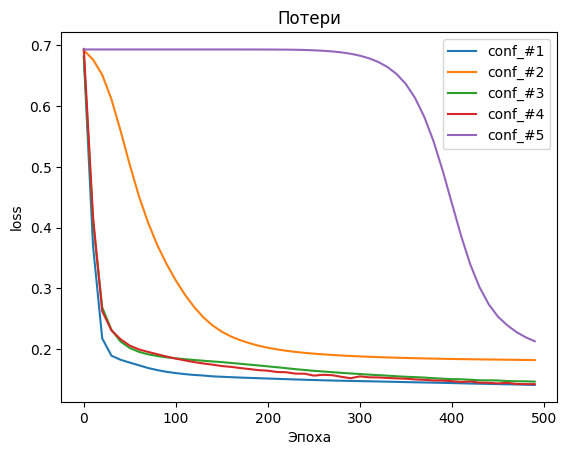

In [252]:
mlp_losses = {
    'conf_#1': my_mlp_results_df['losses'][0],
    'conf_#2': my_mlp_results_df['losses'][1],
    'conf_#3': my_mlp_results_df['losses'][2],
    'conf_#4': my_mlp_results_df['losses'][3],
    'conf_#5': my_mlp_results_df['losses'][4],
}
mlp_losses = pd.DataFrame(mlp_losses)
mlp_losses.index = pd.RangeIndex(0, epochs, 10)

ax = mlp_losses.plot()
ax.legend(loc='upper right')

plt.ylabel('loss')
plt.xlabel('Эпоха')
plt.title('Потери')

#### MLPClassifier

In [253]:
mlp_classifier_resuts = {}

In [254]:
%%time
for id, config in enumerate(config_list):
  hidden_layers = tuple(config['layers'][1:-1])
  lib_mlp = MLPClassifier(
      hidden_layer_sizes=hidden_layers,
      activation='relu',
      learning_rate_init=config['lr'],
      solver='sgd',
      max_iter=epochs,
      batch_size='auto',
      alpha=0,
      random_state=42
  )

  start_time = time.time()
  lib_mlp.fit(X_train, y_train)
  train_time = round(time.time() - start_time, 4)

  start_time = time.time()
  y_pred = lib_mlp.predict(X_test)
  inference_time = round(time.time() - start_time, 4)

  mlp_classifier_resuts[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'train_time': train_time,
      'inference_time': inference_time,
      'accuracy_score': accuracy_score(y_test, y_pred)
  }

CPU times: user 46 s, sys: 93.6 ms, total: 46.1 s
Wall time: 30.7 s


In [255]:
mlp_classifier_resuts_df = pd.DataFrame.from_dict(mlp_classifier_resuts).T
mlp_classifier_resuts_df

,layers,activations,learning_rate,train_time,inference_time,accuracy_score
0,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.01,1.6831,0.0009,0.955
1,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.005,2.3246,0.0006,0.955
2,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.01,1.6122,0.0008,0.955
3,"[2, 64, 128, 32, 1]","[ReLU, sigmoid, ReLU, sigmoid]",0.025,9.2594,0.0018,0.9575
4,"[2, 256, 128, 64, 32, 16, 1]","[ReLU, sigmoid, ReLU, ReLU, ReLU, sigmoid]",0.008,15.7805,0.0037,0.9575


#### PyTorch

In [256]:
torch_classifier_resuts = {}

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

In [257]:
%%time
for id, config in enumerate(config_list):
  torch_layers, torch_loss = map_layers_to_torch_api(config, 'binary_cross_entropy')
  model = nn.Sequential(*torch_layers).to(device)
  optimizer = optim.Adam(model.parameters(), lr=config['lr'])

  start_time = time.time()

  model.train()
  for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(X_train_torch)
    loss = torch_loss(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()

  train_time = round(time.time() - start_time, 4)

  start_time = time.time()

  model.eval()
  with torch.no_grad():
    y_pred_test = model(X_test_torch).numpy()
    y_pred_test = (y_pred_test > 0.5).astype(int)

    inference_time = round(time.time() - start_time, 4)

    torch_classifier_resuts[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'train_time': train_time,
      'inference_time': inference_time,
      'accuracy_score': accuracy_score(y_test, y_pred_test)
    }

CPU times: user 17.8 s, sys: 21.7 ms, total: 17.8 s
Wall time: 18 s


In [258]:
torch_classifier_resuts_df = pd.DataFrame.from_dict(torch_classifier_resuts).T
torch_classifier_resuts_df

,layers,activations,learning_rate,train_time,inference_time,accuracy_score
0,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.01,1.3454,0.0005,0.9575
1,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.005,1.3109,0.0013,0.9575
2,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.01,1.2593,0.0005,0.9575
3,"[2, 64, 128, 32, 1]","[ReLU, sigmoid, ReLU, sigmoid]",0.025,4.9364,0.0013,0.955
4,"[2, 256, 128, 64, 32, 16, 1]","[ReLU, sigmoid, ReLU, ReLU, ReLU, sigmoid]",0.008,9.0797,0.0016,0.9575


#### Keras

In [259]:
keras_classifier_resuts = {}

In [260]:
%%time
for id, config in enumerate(config_list):
  model, keras_loss = map_layers_to_keras_api(config, 'binary_cross_entropy')

  start_time = time.time()
  model.compile(optimizer=optimizers.Adam(learning_rate=config['lr']), loss=keras_loss,metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=epochs, batch_size=config['batch_size'], verbose=0)

  train_time = round(time.time() - start_time, 4)

  start_time = time.time()
  y_pred = model.predict(X_test)
  inference_time = round(time.time() - start_time, 4)

  y_pred = (y_pred > 0.5).astype(int)

  keras_classifier_resuts[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'train_time': train_time,
      'inference_time': inference_time,
      'accuracy_score': accuracy_score(y_test, y_pred)
  }

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
CPU times: user 8min 41s, sys: 18.8 s, total: 8min 59s
Wall time: 9min 49s


In [261]:
keras_classifier_resuts_df = pd.DataFrame.from_dict(keras_classifier_resuts).T
keras_classifier_resuts_df

,layers,activations,learning_rate,train_time,inference_time,accuracy_score
0,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.01,137.6496,0.2734,0.9575
1,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.005,83.1405,0.263,0.955
2,"[2, 32, 16, 1]","[ReLU, ReLU, sigmoid]",0.01,133.407,0.2568,0.95
3,"[2, 64, 128, 32, 1]","[ReLU, sigmoid, ReLU, sigmoid]",0.025,149.1428,0.283,0.9475
4,"[2, 256, 128, 64, 32, 16, 1]","[ReLU, sigmoid, ReLU, ReLU, ReLU, sigmoid]",0.008,84.2602,0.3379,0.9475


#### Результаты

In [262]:
config_labels = ['conf_#1', 'conf_#2', 'conf_#3', 'conf_#4', 'conf_#5']

Text(0.5, 1.0, 'Сравнение моделей по score')

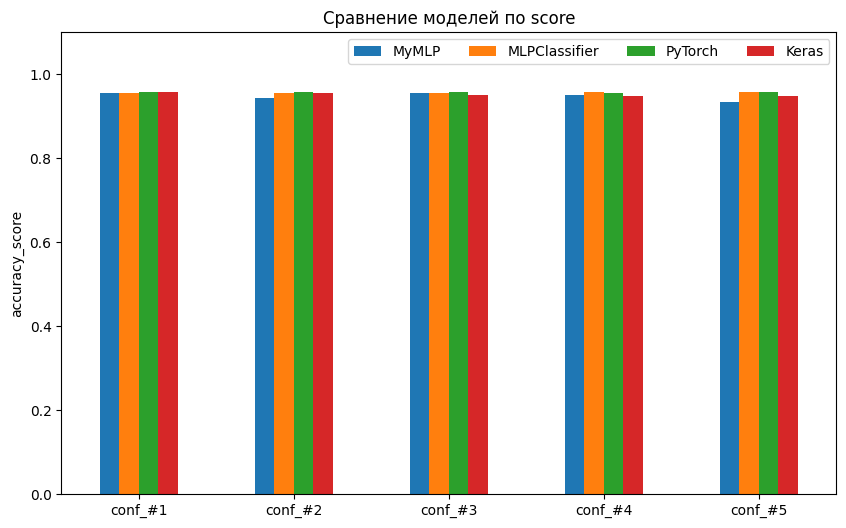

In [263]:
scores = {
    'MyMLP': my_mlp_results_df['accuracy_score'],
    'MLPClassifier': mlp_classifier_resuts_df['accuracy_score'],
    'PyTorch': torch_classifier_resuts_df['accuracy_score'],
    'Keras': keras_classifier_resuts_df['accuracy_score']
}

df_scores = pd.DataFrame(scores)
ax = df_scores.plot(kind='bar', figsize=(10, 6))

ax.legend(loc='upper right', ncols=4)
ax.set_ylim(0, 1.1)
ax.set_xticklabels(config_labels, rotation=0)

plt.ylabel('accuracy_score')
plt.title('Сравнение моделей по score')

### Классификация (многоклассовая)

In [264]:
X, y = make_classification(
    n_features=50,
    n_redundant=0,
    n_classes=6,
    n_informative=40,
    random_state=42,
    n_samples=2000,
    n_clusters_per_class=1
)

y_encoded = one_hot_encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [265]:
input_layer = X_train.shape[1]
output_layer = y_encoded[0].size

config_list = [
    {
        'layers': [input_layer, 36, output_layer],
        'activations': ['ReLU', 'softmax'],
        'batch_size': None,
        'regularization': None,
        'lr': 0.001
    },
    {
        'layers': [input_layer, 36, output_layer],
        'activations': ['ReLU', 'softmax'],
        'batch_size': None,
        'regularization': 'l1',
        'lr': 0.01
    },
    {
        'layers': [input_layer, 28, output_layer],
        'activations': ['ReLU', 'softmax'],
        'batch_size': None,
        'regularization': 'l2',
        'lr': 0.001
    },
    {
        'layers': [input_layer, 64, 32, output_layer],
        'activations': ['ReLU', 'ReLU', 'softmax'],
        'regularization': None,
        'batch_size': None,
        'lr': 0.01
    },
    {
        'layers': [input_layer, 64, 32, 16, output_layer],
        'activations': ['ReLU', 'ReLU', 'ReLU', 'softmax'],
        'regularization': None,
        'batch_size': 32,
        'lr': 0.001
    }
]

#### MyMLP

In [266]:
my_mlp_results = {}

In [267]:
%%time
for id, config in enumerate(config_list):
  my_mlp = MyMLP(
    layers=config['layers'],
    verbose=False,
    batch_size=config['batch_size'],
    activations=config['activations'],
    learning_rate=config['lr'],
    loss='categorical_cross_entropy'
  )

  start_time = time.time()
  my_mlp.fit(X_train, y_train)
  train_time = round(time.time() - start_time, 4)

  start_time = time.time()
  y_pred = my_mlp.predict(X_test)

  inference_time = round(time.time() - start_time, 4)

  my_mlp_results[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'regularization': config['regularization'],
      'losses': my_mlp.epochs_loss,
      'train_time': train_time,
      'inference_time': inference_time,
      'accuracy_score': accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  }

CPU times: user 37.8 s, sys: 65.9 ms, total: 37.8 s
Wall time: 25.3 s


In [268]:
my_mlp_results_df = pd.DataFrame.from_dict(my_mlp_results).T
my_mlp_results_df

,layers,activations,learning_rate,regularization,losses,train_time,inference_time,accuracy_score
0,"[50, 36, 6]","[ReLU, softmax]",0.001,None,"[1.7890285249675635, 1.758159674676042, 1.7150...",1.8065,0.0005,0.825
1,"[50, 36, 6]","[ReLU, softmax]",0.01,l1,"[1.765109904326104, 1.0442281600855565, 0.5344...",5.3922,0.0005,0.85
2,"[50, 28, 6]","[ReLU, softmax]",0.001,l2,"[1.7895055953883463, 1.7642324056026417, 1.729...",1.5034,0.0004,0.81
3,"[50, 64, 32, 6]","[ReLU, ReLU, softmax]",0.01,None,"[1.7804877600580085, 0.8407701144455291, 0.518...",3.8231,0.001,0.8575
4,"[50, 64, 32, 16, 6]","[ReLU, ReLU, ReLU, softmax]",0.001,None,"[1.7917082270379998, 1.7912052180310818, 1.790...",12.7611,0.001,0.4925


Text(0.5, 1.0, 'Потери')

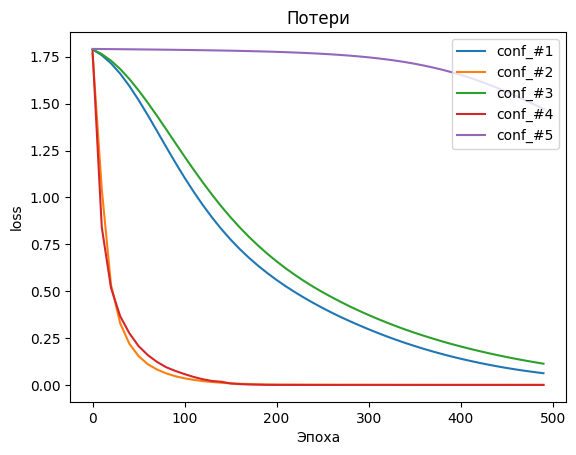

In [269]:
mlp_losses = {
    'conf_#1': my_mlp_results_df['losses'][0],
    'conf_#2': my_mlp_results_df['losses'][1],
    'conf_#3': my_mlp_results_df['losses'][2],
    'conf_#4': my_mlp_results_df['losses'][3],
    'conf_#5': my_mlp_results_df['losses'][4],
}
mlp_losses = pd.DataFrame(mlp_losses)
mlp_losses.index = pd.RangeIndex(0, epochs, 10)

ax = mlp_losses.plot()
ax.legend(loc='upper right')

plt.ylabel('loss')
plt.xlabel('Эпоха')
plt.title('Потери')

#### MLPClassifier

In [270]:
mlp_classifier_resuts = {}

In [271]:
%%time
for id, config in enumerate(config_list):
  hidden_layers = tuple(config['layers'][1:-1])
  lib_mlp = MLPClassifier(
      hidden_layer_sizes=hidden_layers,
      activation='relu',
      learning_rate_init=config['lr'],
      solver='sgd',
      max_iter=epochs,
      batch_size=config['batch_size'] if config['batch_size'] else 'auto',
      alpha=0,
      random_state=42
  )

  start_time = time.time()
  lib_mlp.fit(X_train, y_train)
  train_time = round(time.time() - start_time, 4)

  start_time = time.time()
  y_pred = lib_mlp.predict(X_test)
  inference_time = round(time.time() - start_time, 4)

  mlp_classifier_resuts[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'regularization': config['regularization'],
      'train_time': train_time,
      'inference_time': inference_time,
      'accuracy_score': accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  }

CPU times: user 23.5 s, sys: 29.8 ms, total: 23.5 s
Wall time: 20.3 s


In [272]:
mlp_classifier_resuts_df = pd.DataFrame.from_dict(mlp_classifier_resuts).T
mlp_classifier_resuts_df

,layers,activations,learning_rate,regularization,train_time,inference_time,accuracy_score
0,"[50, 36, 6]","[ReLU, softmax]",0.001,None,2.7759,0.0011,0.6875
1,"[50, 36, 6]","[ReLU, softmax]",0.01,l1,2.9241,0.0222,0.7725
2,"[50, 28, 6]","[ReLU, softmax]",0.001,l2,3.7935,0.0011,0.6725
3,"[50, 64, 32, 6]","[ReLU, ReLU, softmax]",0.01,None,3.5815,0.0013,0.82
4,"[50, 64, 32, 16, 6]","[ReLU, ReLU, ReLU, softmax]",0.001,None,7.1263,0.0167,0.7725


#### PyTorch

In [273]:
torch_classifier_resuts = {}

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

In [274]:
%%time
for id, config in enumerate(config_list):
  torch_layers, torch_loss = map_layers_to_torch_api(config, 'categorical_cross_entropy')
  model = nn.Sequential(*torch_layers).to(device)
  optimizer = optim.Adam(model.parameters(), lr=config['lr'])

  start_time = time.time()

  model.train()
  for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(X_train_torch)
    loss = torch_loss(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()

  train_time = round(time.time() - start_time, 4)

  start_time = time.time()

  model.eval()
  with torch.no_grad():
    y_pred_test = model(X_test_torch).numpy()
    y_pred_test = (y_pred_test > 0.5).astype(int)

    inference_time = round(time.time() - start_time, 4)

    torch_classifier_resuts[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'regularization': config['regularization'],
      'train_time': train_time,
      'inference_time': inference_time,
      'accuracy_score': accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_test, axis=1))
    }

CPU times: user 13.6 s, sys: 23.5 ms, total: 13.7 s
Wall time: 13.9 s


In [275]:
torch_classifier_resuts_df = pd.DataFrame.from_dict(torch_classifier_resuts).T
torch_classifier_resuts_df

,layers,activations,learning_rate,regularization,train_time,inference_time,accuracy_score
0,"[50, 36, 6]","[ReLU, softmax]",0.001,None,2.8525,0.0009,0.7925
1,"[50, 36, 6]","[ReLU, softmax]",0.01,l1,2.193,0.0006,0.8125
2,"[50, 28, 6]","[ReLU, softmax]",0.001,l2,2.104,0.0006,0.74
3,"[50, 64, 32, 6]","[ReLU, ReLU, softmax]",0.01,None,2.9704,0.0008,0.83
4,"[50, 64, 32, 16, 6]","[ReLU, ReLU, ReLU, softmax]",0.001,None,3.7557,0.0011,0.8275


#### Keras

In [276]:
keras_classifier_resuts = {}

In [277]:
%%time
for id, config in enumerate(config_list):
  model, keras_loss = map_layers_to_keras_api(config, 'categorical_cross_entropy')

  start_time = time.time()
  model.compile(optimizer=optimizers.Adam(learning_rate=config['lr']), loss=keras_loss,metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=epochs, batch_size=config['batch_size'], verbose=0)

  train_time = round(time.time() - start_time, 4)

  start_time = time.time()
  y_pred = model.predict(X_test)
  inference_time = round(time.time() - start_time, 4)

  y_pred = (y_pred > 0.5).astype(int)

  keras_classifier_resuts[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'regularization': config['regularization'],
      'train_time': train_time,
      'inference_time': inference_time,
      'accuracy_score': accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  }

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
CPU times: user 9min 27s, sys: 20.3 s, total: 9min 47s
Wall time: 10min 48s


In [278]:
keras_classifier_resuts_df = pd.DataFrame.from_dict(keras_classifier_resuts).T
keras_classifier_resuts_df

,layers,activations,learning_rate,regularization,train_time,inference_time,accuracy_score
0,"[50, 36, 6]","[ReLU, softmax]",0.001,None,127.7996,0.2512,0.86
1,"[50, 36, 6]","[ReLU, softmax]",0.01,l1,126.0969,0.4326,0.8525
2,"[50, 28, 6]","[ReLU, softmax]",0.001,l2,125.4409,0.2434,0.7925
3,"[50, 64, 32, 6]","[ReLU, ReLU, softmax]",0.01,None,133.7966,0.25,0.8975
4,"[50, 64, 32, 16, 6]","[ReLU, ReLU, ReLU, softmax]",0.001,None,133.7765,0.3851,0.8175


#### Результаты

Text(0.5, 1.0, 'Сравнение моделей по score')

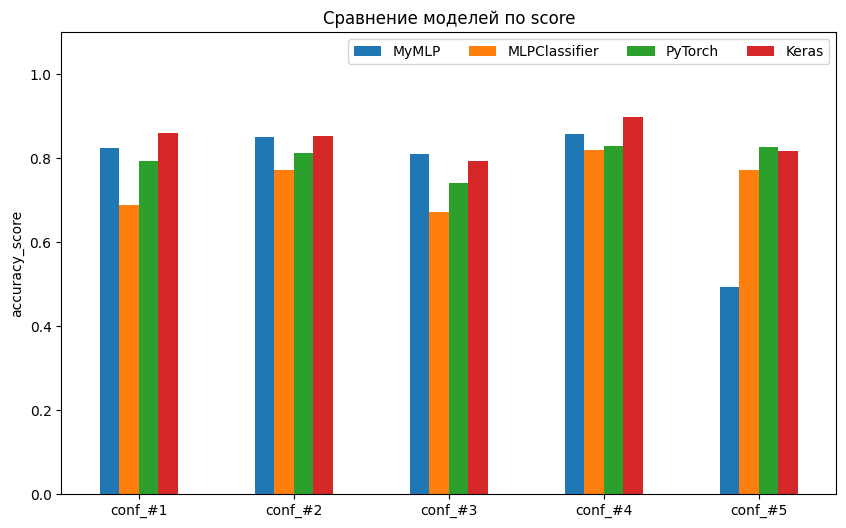

In [279]:
scores = {
    'MyMLP': my_mlp_results_df['accuracy_score'],
    'MLPClassifier': mlp_classifier_resuts_df['accuracy_score'],
    'PyTorch': torch_classifier_resuts_df['accuracy_score'],
    'Keras': keras_classifier_resuts_df['accuracy_score']
}

df_scores = pd.DataFrame(scores)
ax = df_scores.plot(kind='bar', figsize=(10, 6))

ax.legend(loc='upper right', ncols=4)
ax.set_ylim(0, 1.1)
ax.set_xticklabels(config_labels, rotation=0)

plt.ylabel('accuracy_score')
plt.title('Сравнение моделей по score')

### Регрессия

In [280]:
housing = fetch_california_housing()
X = housing.data[:3000]
y = housing.target[:3000].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [300]:
input_layer = X_train.shape[1]

config_list = [
    {
        'layers': [input_layer, 32, 16, 1],
        'activations': ['ReLU', 'ReLU', 'linear'],
        'batch_size': None,
        'regularization': None,
        'lr': 0.01
    },
    {
        'layers': [input_layer, 32, 16, 1],
        'activations': ['ReLU', 'ReLU', 'linear'],
        'batch_size': 64,
        'regularization': 'l1',
        'lr': 0.005
    },
    {
        'layers': [input_layer, 32, 16, 1],
        'activations': ['ReLU', 'ReLU', 'linear'],
        'batch_size': None,
        'regularization': 'l2',
        'lr': 0.01
    },
    {
        'layers': [input_layer, 16, 1],
        'activations': ['ReLU', 'linear'],
        'batch_size': None,
        'regularization': None,
        'lr': 0.001
    },
    {
        'layers': [input_layer, 4, 1],
        'activations': ['ReLU', 'linear'],
        'batch_size': 32,
        'regularization': None,
        'lr': 0.001
    }
]

#### MyMLP

In [301]:
my_mlp_results = {}

In [302]:
%%time
for id, config in enumerate(config_list):
  my_mlp = MyMLP(
    layers=config['layers'],
    verbose=False,
    batch_size=config['batch_size'],
    activations=config['activations'],
    learning_rate=config['lr'],
    loss='mse'
  )

  start_time = time.time()
  my_mlp.fit(X_train, y_train)
  train_time = round(time.time() - start_time, 4)

  start_time = time.time()
  y_pred = my_mlp.predict(X_test)
  inference_time = round(time.time() - start_time, 4)

  my_mlp_results[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'regularization': config['regularization'],
      'losses': my_mlp.epochs_loss,
      'train_time': train_time,
      'inference_time': inference_time,
      'mse': mean_squared_error(y_test, y_pred)
  }

CPU times: user 23.1 s, sys: 54.6 ms, total: 23.2 s
Wall time: 16 s


In [303]:
my_mlp_results_df = pd.DataFrame.from_dict(my_mlp_results).T
my_mlp_results_df

,layers,activations,learning_rate,regularization,losses,train_time,inference_time,mse
0,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.01,None,"[3.2354041956150015, 2.4996339152890537, 1.813...",1.7262,0.0003,0.173319
1,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.005,l1,"[3.2919336156839774, 3.070176045307679, 2.8610...",7.1743,0.0004,0.313108
2,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.01,l2,"[3.2321166330946727, 2.452907809365305, 1.6684...",2.8997,0.0004,0.18149
3,"[8, 16, 1]","[ReLU, linear]",0.001,None,"[3.2995015856216194, 3.1495530418445856, 3.008...",0.4321,0.0001,0.635993
4,"[8, 4, 1]","[ReLU, linear]",0.001,None,"[3.3032522982779655, 3.187981336378123, 3.0760...",3.7285,0.0001,0.336023


Text(0.5, 1.0, 'Потери')

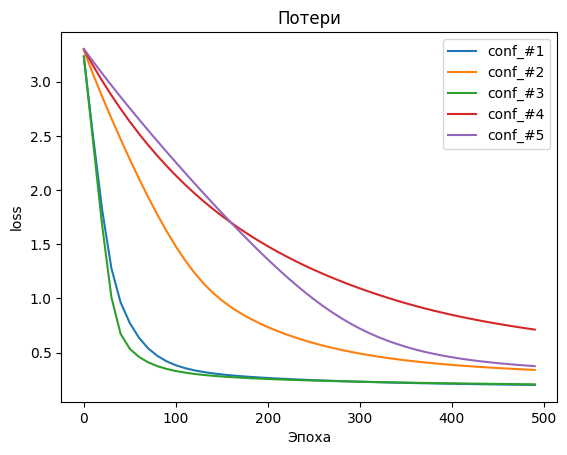

In [304]:
mlp_losses = {
    'conf_#1': my_mlp_results_df['losses'][0],
    'conf_#2': my_mlp_results_df['losses'][1],
    'conf_#3': my_mlp_results_df['losses'][2],
    'conf_#4': my_mlp_results_df['losses'][3],
    'conf_#5': my_mlp_results_df['losses'][4],
}
mlp_losses = pd.DataFrame(mlp_losses)
mlp_losses.index = pd.RangeIndex(0, epochs, 10)

ax = mlp_losses.plot()
ax.legend(loc='upper right')

plt.ylabel('loss')
plt.xlabel('Эпоха')
plt.title('Потери')

#### MLPRegressor

In [305]:
mlp_regressor_resuts = {}

In [306]:
%%time
for id, config in enumerate(config_list):
  hidden_layers = tuple(config['layers'][1:-1])
  lib_mlp = MLPRegressor(
      hidden_layer_sizes=hidden_layers,
      activation='relu',
      learning_rate_init=config['lr'],
      solver='sgd',
      max_iter=epochs,
      batch_size=config['batch_size'] if config['batch_size'] else 'auto',
      alpha=0,
      random_state=42
  )

  start_time = time.time()
  lib_mlp.fit(X_train, y_train)
  train_time = round(time.time() - start_time, 4)

  start_time = time.time()
  y_pred = lib_mlp.predict(X_test)
  inference_time = round(time.time() - start_time, 4)

  mlp_regressor_resuts[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'regularization': config['regularization'],
      'train_time': train_time,
      'inference_time': inference_time,
      'mse': mean_squared_error(y_test, y_pred)
  }

CPU times: user 11.6 s, sys: 31.4 ms, total: 11.6 s
Wall time: 11.8 s


In [307]:
mlp_regressor_resuts_df = pd.DataFrame.from_dict(mlp_regressor_resuts).T
mlp_regressor_resuts_df

,layers,activations,learning_rate,regularization,train_time,inference_time,mse
0,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.01,None,2.204,0.0007,0.128492
1,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.005,l1,3.0806,0.0008,0.121916
2,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.01,l2,3.1517,0.0006,0.128492
3,"[8, 16, 1]","[ReLU, linear]",0.001,None,0.5254,0.0005,0.171661
4,"[8, 4, 1]","[ReLU, linear]",0.001,None,2.8367,0.0005,0.164513


#### PyTorch

In [308]:
torch_regressor_resuts = {}

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

In [309]:
%%time
for id, config in enumerate(config_list):
  torch_layers, torch_loss = map_layers_to_torch_api(config, 'mse')
  model = nn.Sequential(*torch_layers).to(device)
  optimizer = optim.Adam(model.parameters(), lr=config['lr'])

  start_time = time.time()

  model.train()
  for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(X_train_torch)
    loss = torch_loss(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()

  train_time = round(time.time() - start_time, 4)

  start_time = time.time()

  model.eval()
  with torch.no_grad():
    y_pred_test = model(X_test_torch).numpy()

    inference_time = round(time.time() - start_time, 4)

    torch_regressor_resuts[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'regularization': config['regularization'],
      'train_time': train_time,
      'inference_time': inference_time,
      'mse': mean_squared_error(y_test, y_pred_test)
    }

CPU times: user 5.58 s, sys: 14.6 ms, total: 5.6 s
Wall time: 5.62 s


In [310]:
torch_regressor_resuts_df = pd.DataFrame.from_dict(torch_regressor_resuts).T
torch_regressor_resuts_df

,layers,activations,learning_rate,regularization,train_time,inference_time,mse
0,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.01,None,1.3439,0.0004,0.128785
1,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.005,l1,1.4085,0.0005,0.125286
2,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.01,l2,1.3684,0.0004,0.125326
3,"[8, 16, 1]","[ReLU, linear]",0.001,None,0.7993,0.0003,0.184703
4,"[8, 4, 1]","[ReLU, linear]",0.001,None,0.6888,0.0002,0.360572


#### Keras

In [311]:
keras_regressor_resuts = {}

In [312]:
%%time
for id, config in enumerate(config_list):
  model, keras_loss = map_layers_to_keras_api(config, 'mse')

  start_time = time.time()
  model.compile(optimizer=optimizers.Adam(learning_rate=config['lr']), loss=keras_loss, metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=epochs, batch_size=config['batch_size'], verbose=0)

  train_time = round(time.time() - start_time, 4)

  start_time = time.time()
  y_pred = model.predict(X_test)
  inference_time = round(time.time() - start_time, 4)

  keras_regressor_resuts[id] = {
      'layers': config['layers'],
      'activations': config['activations'],
      'learning_rate': config['lr'],
      'regularization': config['regularization'],
      'train_time': train_time,
      'inference_time': inference_time,
      'mse': mean_squared_error(y_test, y_pred)
  }

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
CPU times: user 11min 35s, sys: 25.5 s, total: 12min
Wall time: 12min 41s


In [313]:
keras_regressor_resuts_df = pd.DataFrame.from_dict(keras_regressor_resuts).T
keras_regressor_resuts_df

,layers,activations,learning_rate,regularization,train_time,inference_time,mse
0,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.01,None,160.5297,0.4368,0.152017
1,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.005,l1,110.6196,0.4215,0.140606
2,"[8, 32, 16, 1]","[ReLU, ReLU, linear]",0.01,l2,168.0602,0.3894,0.155465
3,"[8, 16, 1]","[ReLU, linear]",0.001,None,159.4116,0.2534,0.153203
4,"[8, 4, 1]","[ReLU, linear]",0.001,None,161.1105,0.4749,0.136113


#### Результаты

Text(0.5, 1.0, 'Сравнение моделей по score')

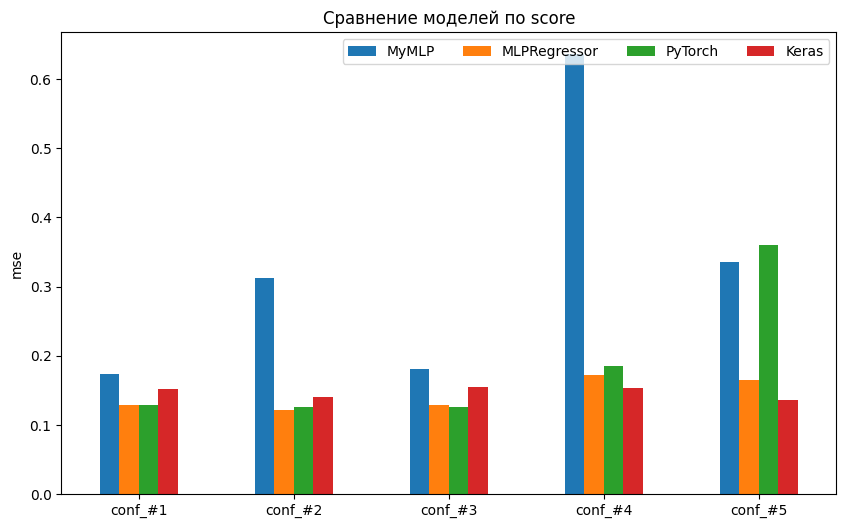

In [314]:
scores = {
    'MyMLP': my_mlp_results_df['mse'],
    'MLPRegressor': mlp_regressor_resuts_df['mse'],
    'PyTorch': torch_regressor_resuts_df['mse'],
    'Keras': keras_regressor_resuts_df['mse']
}

df_scores = pd.DataFrame(scores)
ax = df_scores.plot(kind='bar', figsize=(10, 6))

ax.legend(loc='upper right', ncols=4)
ax.set_xticklabels(config_labels, rotation=0)

plt.ylabel('mse')
plt.title('Сравнение моделей по score')